# Part II: Training our Model

Now that we have a relatively tidy and balanced dataset of images, it is time to use them to train a classification model. We will be designing a Convolutional Neural Network to perform this task.

As CNNs require a lot of processing power to be trained, we will make use of the GPUs available through Google's colab service to complete this task. Therefore, there will be a couple of steps taken along the way to take care of that. In any case, our trained model can be stored and deployed in any machine, offline and without the need of GPUs.

## Reading in our Data

In [1]:
# This step is to mount our Google drive on this notebook:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


With the Google Drive mounted, we can import our dataset to colab: 

In [2]:
TRAIN_DIR = '/content/drive/MyDrive/EUPNOOS/COUGH/DATA/train_mfccs/'
TEST_DIR = '/content/drive/MyDrive/EUPNOOS/COUGH/DATA/test_mfccs/'

Now that the Google part is taken care of, we can go on with our standard approach on such tasks. First, we import the necessary libraries:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

We are using Tensorflow and Keras for this, therefore the dataset must follow the necessary pipeline before being fed to the model. We perform a train/validation split on the training data, make sure images are properly sized and scaled, and define a batch size.

In [8]:
datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)

WIDTH = 224
HEIGHT = 224
BATCH_SIZE = 24

train_generator = datagen.flow_from_directory(
    TRAIN_DIR, 
    target_size=(HEIGHT, WIDTH), 
    subset='training',
    batch_size=BATCH_SIZE,
		class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH), 
    subset='validation',
    batch_size=BATCH_SIZE,
		class_mode='categorical'
)


Found 1033 images belonging to 2 classes.
Found 257 images belonging to 2 classes.


Let's have a look at a few of our data. The classes correspond to: 0 for cough events, and 1 for no-cough events.

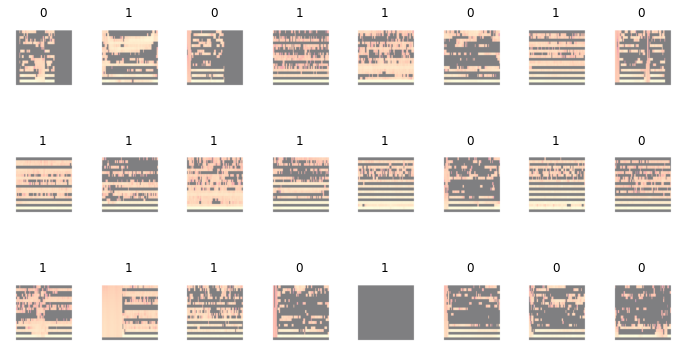

In [9]:
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(12, 9))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
    plt.subplot(4, 8, k+1)
    plt.imshow((img + 1) / 2)
    plt.title(int(lbl[1]))
    plt.axis('off')

Now that we have a larger number of examples, it is actually a bit easier even for us humans to distinguish a few features that distinguish each class. This is already encouraging.

## Defining Hyperparameters

We will setup the number of epochs, and steps to be taken per epoch.

In [10]:
def calculate_spe(y):
  return int(round((1. * y) / BATCH_SIZE))

STEPS_PER_EPOCH = calculate_spe(1033*0.8)
VALIDATION_STEPS = calculate_spe(1033*0.2)

EPOCHS = 20

It is also useful to use a few callbacks. Setting up an early stopping callback will help avoid overfitting the model to our training data, while modifying the learning rate can help optimise the model weights more efficiently.

In [13]:
from tensorflow import keras
my_callbacks = [
    keras.callbacks.EarlyStopping(patience=5),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.00001, mode='min')
]

## Convolutional Neural Network

This is the architecure of our CNN. We make use of dropout layers to improve the quality of our training. The final layer uses a softmax activation for two classes.

In [17]:
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import pandas as pd

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(HEIGHT,WIDTH,3)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))


model.compile(optimizers.Adam(lr=0.0001, epsilon=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
activation_14 (Activation)   (None, 224, 224, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 222, 222, 64)      18496     
_________________________________________________________________
activation_15 (Activation)   (None, 222, 222, 64)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 111, 111, 64)      0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 111, 111, 64)     

And now we train our model using the designated hyperparameters.

In [18]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=val_generator,
    validation_steps=VALIDATION_STEPS,
    callbacks=my_callbacks)

Epoch 1/20
34/34 [==============================] - 338s 10s/step - loss: 0.7253 - accuracy: 0.5921 - val_loss: 0.6279 - val_accuracy: 0.6111
Epoch 2/20
34/34 [==============================] - 43s 1s/step - loss: 0.3934 - accuracy: 0.8420 - val_loss: 0.5396 - val_accuracy: 0.7222
Epoch 3/20
34/34 [==============================] - 13s 402ms/step - loss: 0.2561 - accuracy: 0.9203 - val_loss: 0.5795 - val_accuracy: 0.7176
Epoch 4/20
34/34 [==============================] - 6s 169ms/step - loss: 0.1698 - accuracy: 0.9381 - val_loss: 0.5014 - val_accuracy: 0.7685
Epoch 5/20
34/34 [==============================] - 5s 146ms/step - loss: 0.1596 - accuracy: 0.9293 - val_loss: 0.5416 - val_accuracy: 0.7731
Epoch 6/20
34/34 [==============================] - 5s 139ms/step - loss: 0.1174 - accuracy: 0.9448 - val_loss: 0.4006 - val_accuracy: 0.8935
Epoch 7/20
34/34 [==============================] - 5s 140ms/step - loss: 0.1202 - accuracy: 0.9587 - val_loss: 0.4550 - val_accuracy: 0.8611
Epoch 8

The training process stopped early due to our callbacks. Let's see it visualised:

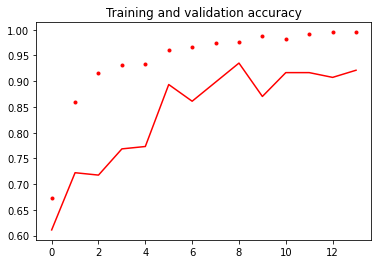

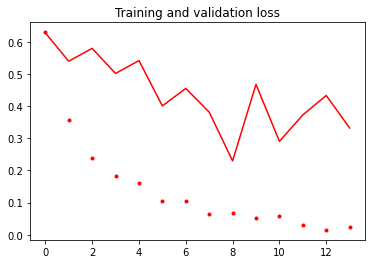

In [19]:
def plot_training(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))
  
  plt.plot(epochs, acc, 'r.')
  plt.plot(epochs, val_acc, 'r')
  plt.title('Training and validation accuracy')
  
  plt.figure()
  plt.plot(epochs, loss, 'r.')
  plt.plot(epochs, val_loss, 'r-')
  plt.title('Training and validation loss')
  plt.show()
  
plot_training(history)

We can see how we have reached a good level of validation accuracy and avoided overfitting. It's time to save our trained model so we can deploy it anytime, almost anywhere.

In [20]:
model.save('/content/drive/MyDrive/Colab_Models/model_CoughDetectionCNN.h5')

## Evaluate on Test Data

Now the moment of truth. We have designated a separate test dataset, comprising of a few samples which the network has never seen during its training. Cough examples in this test data are from people who were not included in the training data, so we can be sure that our model can pick up cough regardless of the person.

In [21]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(HEIGHT, WIDTH), 
		class_mode='categorical'
)

Found 58 images belonging to 2 classes.


In [23]:
score, acc = model.evaluate(test_generator)
print('Test score:', score)
print('Test accuracy:', acc)

2/2 [==============================] - 0s 81ms/step - loss: 0.0616 - accuracy: 0.9828
Test score: 0.06160824000835419
Test accuracy: 0.982758641242981


Our test accuracy is over 98%. This is an outstanding outcome, even surpassing our validation accuracy. We can be confident that our model can now be deployed and yield reliable predictions.